# Experiment 2 - Stage 1: Binary Crime Classification with Attention

## Overview
This notebook implements Stage 1 of Experiment 2, which performs binary classification (Normal vs. Crime) on UCF Crime videos.

### Key Features:
1. **Improved Data Ingestion**: Uses Experiment 1's approach - loading videos directly from MP4 files using OpenCV
2. **Attention Mechanism**: Identifies which frames are most important for crime detection
3. **Gradient Clipping**: Keeps weights stable between 0 and 1
4. **High-Attention Frame Extraction**: Prepares data for Stage 2 by identifying relevant frames

### Stage 1 Goals:
- Train a binary classifier (Normal=0, Crime=1)
- Extract attention weights to identify crime-relevant frames
- Save high-attention data for Stage 2 training

---

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import json
import shutil
import numpy as np
import cv2

In [2]:
class UCFCrimeBinaryDataset(Dataset):
    """
    Dataset that loads videos directly from MP4 files using OpenCV
    (matching Experiment 1's data ingestion approach)
    """
    def __init__(self, root_dir, clip_len=16, transform=None, frame_size=112):
        self.root_dir = root_dir
        self.clip_len = clip_len
        self.transform = transform
        self.frame_size = frame_size

        self.samples = []
        self._prepare_samples()

    def _prepare_samples(self):
        """Scan directory for MP4 video files"""
        for category in os.listdir(self.root_dir):
            category_path = os.path.join(self.root_dir, category)
            if not os.path.isdir(category_path):
                continue

            label = 0 if category.lower() == "normalvideos" else 1  # normal=0, crime=1
            
            # Look for .mp4 files (not directories)
            for file in os.listdir(category_path):
                if file.lower().endswith('.mp4'):
                    video_path = os.path.join(category_path, file)
                    self.samples.append((video_path, label))

    def _load_video_cv2(self, video_path):
        """Load video using OpenCV and extract frames"""
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")

        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Sample frames uniformly across the video
        frame_indices = np.linspace(0, total_frames - 1, self.clip_len, dtype=int)

        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                break
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Resize frame
            frame = cv2.resize(frame, (self.frame_size, self.frame_size))
            frames.append(frame)

        cap.release()

        if len(frames) == 0:
            raise ValueError(f"No frames extracted from: {video_path}")

        # Pad with last frame if needed
        while len(frames) < self.clip_len:
            frames.append(frames[-1])

        return frames

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        
        try:
            # Load frames using OpenCV
            frames = self._load_video_cv2(video_path)
            
            # Convert to tensors
            imgs = []
            for frame in frames:
                # Convert numpy array to PIL Image for transforms
                frame_pil = Image.fromarray(frame)
                if self.transform:
                    frame_tensor = self.transform(frame_pil)
                else:
                    frame_tensor = transforms.ToTensor()(frame_pil)
                imgs.append(frame_tensor)
            
            # Stack as (C, T, H, W)
            clip_tensor = torch.stack(imgs, dim=1)
            return clip_tensor, torch.tensor(label, dtype=torch.long), video_path
            
        except Exception as e:
            print(f"[LOAD FAILED] {video_path} | Error: {e}")
            # Return dummy tensor
            dummy = torch.zeros(3, self.clip_len, self.frame_size, self.frame_size)
            return dummy, torch.tensor(label, dtype=torch.long), video_path


In [3]:
class BinaryCrimeDetector(nn.Module):
    """
    Binary crime detector with attention mechanism for frame importance
    Attention weights help identify which frames are most relevant for crime detection
    """
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(3, 32, (1,3,3), padding=(0,1,1)),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 32, (3,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((1,2,2)),

            nn.Conv3d(32, 64, (1,3,3), padding=(0,1,1)),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, (3,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2))
        )
        
        # Attention mechanism to identify important frames
        self.attention = nn.Sequential(
            nn.Conv3d(64, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 1, kernel_size=1),
            nn.Sigmoid()  # Attention weights between 0 and 1
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(64, 2)
        )

    def forward(self, x, return_attention=False):
        """
        Args:
            x: input tensor (B, C, T, H, W)
            return_attention: if True, return attention weights along with predictions
        
        Returns:
            logits: classification logits (B, 2)
            attention_weights (optional): frame importance weights (B, T)
        """
        features = self.features(x)
        
        # Compute attention weights for each frame
        attention_map = self.attention(features)  # (B, 1, T', H', W')
        
        # Global average pooling over spatial dimensions to get per-frame weights
        attention_weights = attention_map.mean(dim=[3, 4])  # (B, 1, T')
        attention_weights = attention_weights.squeeze(1)  # (B, T')
        
        # Apply attention to features
        weighted_features = features * attention_map
        
        # Classification
        logits = self.classifier(weighted_features)
        
        if return_attention:
            return logits, attention_weights
        return logits


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance
    
    Reference: Lin et al. "Focal Loss for Dense Object Detection"
    https://arxiv.org/abs/1708.02002
    
    Args:
        alpha: Weighting factor in [0, 1] to balance positive/negative examples
               or a list of weights [alpha_class_0, alpha_class_1]
        gamma: Exponent of the modulating factor (1 - p_t)^gamma
               Higher gamma focuses more on hard examples
        reduction: 'mean', 'sum', or 'none'
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        """
        Args:
            inputs: (B, C) logits from model (before softmax)
            targets: (B,) class labels
        """
        # Get probabilities
        p = F.softmax(inputs, dim=1)
        
        # Get class probabilities
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p_t = p.gather(1, targets.view(-1, 1)).squeeze(1)
        
        # Calculate focal loss
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = focal_weight * ce_loss
        
        # Apply alpha weighting
        if isinstance(self.alpha, (float, int)):
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            focal_loss = alpha_t * focal_loss
        elif isinstance(self.alpha, list):
            alpha_t = torch.tensor(self.alpha, device=inputs.device)[targets]
            focal_loss = alpha_t * focal_loss
        
        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class WeightedFocalLoss(nn.Module):
    """
    Focal Loss with automatic class weighting based on dataset statistics
    """
    def __init__(self, num_normal, num_crime, gamma=2.0, reduction='mean'):
        super(WeightedFocalLoss, self).__init__()
        # Calculate inverse frequency weights
        total = num_normal + num_crime
        weight_normal = total / (2.0 * num_normal)
        weight_crime = total / (2.0 * num_crime)
        
        # Normalize weights
        self.alpha = [weight_normal, weight_crime]
        self.gamma = gamma
        self.reduction = reduction
        
        print(f"Weighted Focal Loss initialized:")
        print(f"  Normal weight (alpha_0): {self.alpha[0]:.4f}")
        print(f"  Crime weight (alpha_1): {self.alpha[1]:.4f}")
        print(f"  Gamma: {self.gamma}")
        
    def forward(self, inputs, targets):
        p = F.softmax(inputs, dim=1)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p_t = p.gather(1, targets.view(-1, 1)).squeeze(1)
        
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = focal_weight * ce_loss
        
        # Apply class weights
        alpha_t = torch.tensor(self.alpha, device=inputs.device)[targets]
        focal_loss = alpha_t * focal_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLIP_LEN = 16
FRAME_SIZE = 112

# Transform pipeline (resize is now handled in dataset via OpenCV)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# UPDATE THESE PATHS TO YOUR VIDEO DIRECTORIES (should contain .mp4 files, not frame directories)
train_dir = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2\Train"
test_dir  = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2\Test"

train_data = UCFCrimeBinaryDataset(train_dir, clip_len=CLIP_LEN, transform=transform, frame_size=FRAME_SIZE)
test_data  = UCFCrimeBinaryDataset(test_dir, clip_len=CLIP_LEN, transform=transform, frame_size=FRAME_SIZE)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_data, batch_size=2, shuffle=False, num_workers=0)

print(f"Train clips: {len(train_data)}, Test clips: {len(test_data)}")
print(f"Using device: {DEVICE}")


Train clips: 930, Test clips: 245
Using device: cuda


### Verify Data Distribution
---


In [5]:
def count_videos_per_class(dataset):
    """Count videos per class for verification"""
    from collections import Counter
    labels_count = Counter([label for _, label in dataset.samples])
    
    print("\nClass Distribution:")
    print(f"  Normal (0): {labels_count[0]} videos")
    print(f"  Crime (1): {labels_count[1]} videos")
    print(f"  Total: {len(dataset)} videos")
    return labels_count

print("=" * 60)
print("TRAINING SET")
print("=" * 60)
train_dist = count_videos_per_class(train_data)

print("\n" + "=" * 60)
print("TEST SET")
print("=" * 60)
test_dist = count_videos_per_class(test_data)


TRAINING SET

Class Distribution:
  Normal (0): 170 videos
  Crime (1): 760 videos
  Total: 930 videos

TEST SET

Class Distribution:
  Normal (0): 150 videos
  Crime (1): 95 videos
  Total: 245 videos


### Training with Gradient Clipping & Attention
---


Weighted Focal Loss initialized:
  Normal weight (alpha_0): 2.7353
  Crime weight (alpha_1): 0.6118
  Gamma: 2.0

Starting training with Focal Loss...
Epochs: 5
Gradient clipping: 1.0
Device: cuda



Epoch 1/5: 100%|██████████| 233/233 [04:08<00:00,  1.07s/it]


Epoch 1 | Loss: 0.1618 | Acc: 73.76% | Precision: 0.863 | Recall: 0.807 | F1: 0.834 | LR: 0.000090


Epoch 2/5: 100%|██████████| 233/233 [04:08<00:00,  1.07s/it]


Epoch 2 | Loss: 0.1585 | Acc: 76.13% | Precision: 0.876 | Recall: 0.825 | F1: 0.850 | LR: 0.000065


Epoch 3/5: 100%|██████████| 233/233 [03:39<00:00,  1.06it/s]


Epoch 3 | Loss: 0.1543 | Acc: 76.99% | Precision: 0.899 | Recall: 0.809 | F1: 0.852 | LR: 0.000035


Epoch 4/5: 100%|██████████| 233/233 [03:24<00:00,  1.14it/s]


Epoch 4 | Loss: 0.1514 | Acc: 77.63% | Precision: 0.890 | Recall: 0.829 | F1: 0.858 | LR: 0.000010


Epoch 5/5: 100%|██████████| 233/233 [03:24<00:00,  1.14it/s]


Epoch 5 | Loss: 0.1510 | Acc: 78.92% | Precision: 0.885 | Recall: 0.853 | F1: 0.869 | LR: 0.000000

✓ Model checkpoint saved to: C:\Users\Brandon\Documents\DM_Project\output\binary_stage1_focal_loss.pt


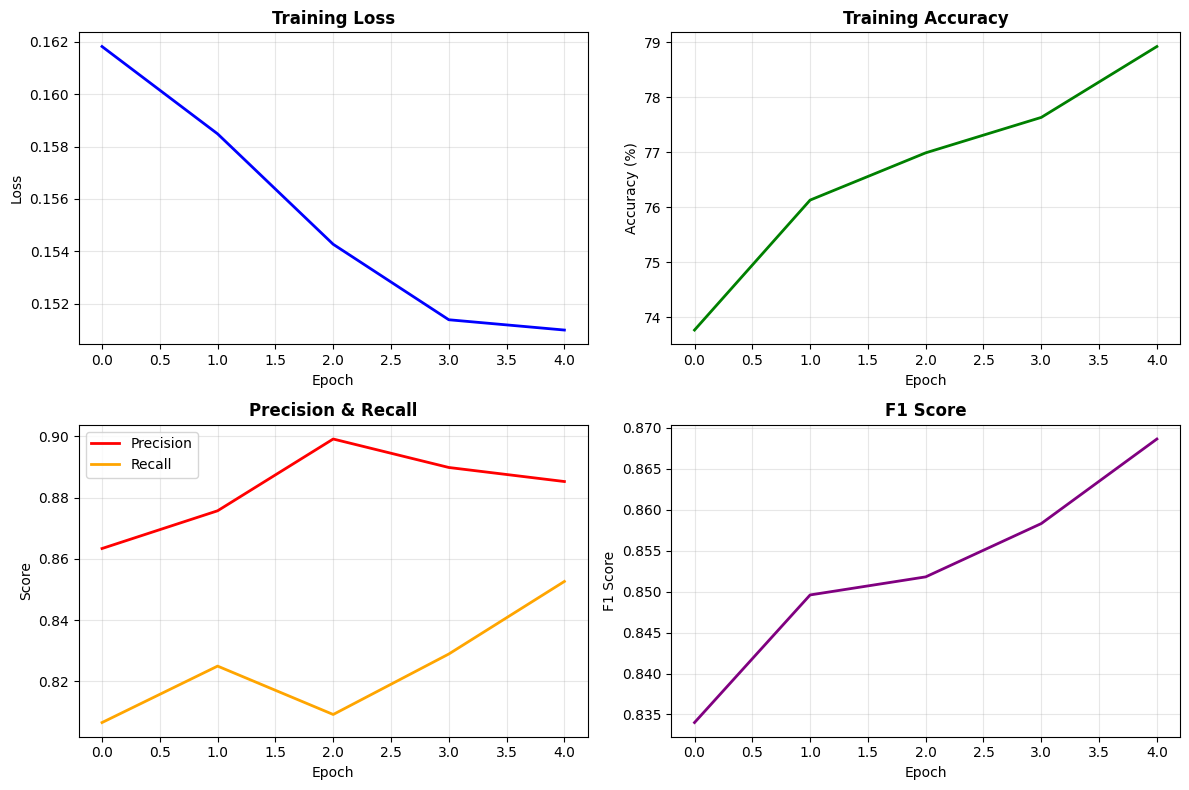

✓ Training metrics saved to: C:\Users\Brandon\Documents\DM_Project\output\training_metrics_focal_loss.png


In [10]:
model = BinaryCrimeDetector().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

# Choose your loss function - Option 1: Weighted Focal Loss (RECOMMENDED)
criterion = WeightedFocalLoss(
    num_normal=train_dist[0],  # From your data distribution
    num_crime=train_dist[1],
    gamma=2.0  # Focus on hard examples
)

# OR Option 2: Manual Focal Loss with custom alpha
# criterion = FocalLoss(alpha=0.25, gamma=2.0)

# OR Option 3: Standard Focal Loss
# criterion = FocalLoss(alpha=0.5, gamma=2.0)

EPOCHS = 5
GRADIENT_CLIP_VALUE = 1.0

print(f"\nStarting training with Focal Loss...")
print(f"Epochs: {EPOCHS}")
print(f"Gradient clipping: {GRADIENT_CLIP_VALUE}")
print(f"Device: {DEVICE}\n")

# Track metrics
training_history = {
    'train_loss': [],
    'train_acc': [],
    'train_precision': [],
    'train_recall': []
}

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # For precision/recall calculation
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for clips, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        clips, labels = clips.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs, attention_weights = model(clips, return_attention=True)
        
        # Calculate focal loss
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VALUE)
        
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy and metrics
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        # Calculate precision/recall components
        true_positives += ((preds == 1) & (labels == 1)).sum().item()
        false_positives += ((preds == 1) & (labels == 0)).sum().item()
        false_negatives += ((preds == 0) & (labels == 1)).sum().item()
    
    # Scheduler step
    scheduler.step()
    
    # Calculate metrics
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Store metrics
    training_history['train_loss'].append(avg_loss)
    training_history['train_acc'].append(accuracy)
    training_history['train_precision'].append(precision)
    training_history['train_recall'].append(recall)
    
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Acc: {accuracy:.2f}% | "
          f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1_score:.3f} | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")

# Save checkpoint
output_dir = r'C:\Users\Brandon\Documents\DM_Project\output'
os.makedirs(output_dir, exist_ok=True)
checkpoint_path = os.path.join(output_dir, "binary_stage1_focal_loss.pt")
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'training_history': training_history,
}, checkpoint_path)
print(f"\n✓ Model checkpoint saved to: {checkpoint_path}")

# Plot training metrics
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(training_history['train_loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Training Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(training_history['train_acc'], 'g-', linewidth=2)
axes[0, 1].set_title('Training Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(training_history['train_precision'], 'r-', linewidth=2, label='Precision')
axes[1, 0].plot(training_history['train_recall'], 'orange', linewidth=2, label='Recall')
axes[1, 0].set_title('Precision & Recall', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

f1_scores = [2 * (p * r) / (p + r + 1e-10) 
             for p, r in zip(training_history['train_precision'], 
                           training_history['train_recall'])]
axes[1, 1].plot(f1_scores, 'purple', linewidth=2)
axes[1, 1].set_title('F1 Score', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_metrics_focal_loss.png'), 
            dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Training metrics saved to: {os.path.join(output_dir, 'training_metrics_focal_loss.png')}")


### Stage 1 Inference - Extract Anomaly Clips with High Attention
---


In [11]:
model.eval()
anomaly_dir = "./stage1_output/anomaly_clips"
attention_output_dir = "./stage1_output/attention_data"
os.makedirs(anomaly_dir, exist_ok=True)
os.makedirs(attention_output_dir, exist_ok=True)

anomaly_records = []
all_attention_data = []

print("\nRunning Stage 1 inference with attention extraction...")
print("=" * 60)

with torch.no_grad():
    for clips, labels, paths in tqdm(test_loader, desc="Stage 1 Inference"):
        clips = clips.to(DEVICE)
        
        # Get predictions and attention weights
        outputs, attention_weights = model(clips, return_attention=True)
        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1).cpu().numpy()
        crime_probs = probs[:,1].cpu().numpy()  # prob of 'crime'
        
        # Process each clip in batch
        for i, pred in enumerate(preds):
            if pred == 1:  # Crime detected
                video_path = paths[i]
                confidence = float(crime_probs[i])
                att_weights = attention_weights[i].cpu().numpy()
                
                # Save video information
                anomaly_records.append({
                    "video_path": video_path,
                    "confidence": confidence,
                    "attention_weights": att_weights.tolist(),
                    "top_attention_indices": np.argsort(att_weights)[-5:].tolist()  # Top 5 frames
                })
                
                # Store attention data for Stage 2
                all_attention_data.append({
                    "video_path": video_path,
                    "confidence": confidence,
                    "attention_weights": att_weights,
                    "clip_tensor": clips[i].cpu()  # Save for potential Stage 2 use
                })

# Save anomaly records as JSON
anomalies_json_path = "./stage1_output/anomalies.json"
with open(anomalies_json_path, "w") as f:
    json.dump(anomaly_records, f, indent=2)

# Save attention data for Stage 2
attention_data_path = os.path.join(attention_output_dir, "stage1_attention_data.pt")
torch.save(all_attention_data, attention_data_path)

print("\n" + "=" * 60)
print(f"✓ Stage 1 Complete!")
print(f"  - Detected {len(anomaly_records)} crime clips")
print(f"  - Anomaly records saved to: {anomalies_json_path}")
print(f"  - Attention data saved to: {attention_data_path}")
print(f"  - Ready for Stage 2 training")
print("=" * 60)



Running Stage 1 inference with attention extraction...


Stage 1 Inference: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]



✓ Stage 1 Complete!
  - Detected 134 crime clips
  - Anomaly records saved to: ./stage1_output/anomalies.json
  - Attention data saved to: ./stage1_output/attention_data\stage1_attention_data.pt
  - Ready for Stage 2 training


Testing different classification thresholds...



Evaluating: 100%|██████████| 123/123 [00:55<00:00,  2.21it/s]



Evaluation Results (Threshold: 0.30)
Accuracy:    0.4082 (40.82%)
Precision:   0.3932 (Of predicted crimes, 39.3% are correct)
Recall:      0.9684 (Of actual crimes, 96.8% are detected)
Specificity: 0.0533 (Of normal videos, 5.3% correctly identified)
F1 Score:    0.5593

Confusion Matrix:
  True Negatives:     8 | False Positives:  142
  False Negatives:    3 | True Positives:    92



Evaluating: 100%|██████████| 123/123 [00:55<00:00,  2.23it/s]



Evaluation Results (Threshold: 0.50)
Accuracy:    0.6776 (67.76%)
Precision:   0.5597 (Of predicted crimes, 56.0% are correct)
Recall:      0.7895 (Of actual crimes, 78.9% are detected)
Specificity: 0.6067 (Of normal videos, 60.7% correctly identified)
F1 Score:    0.6550

Confusion Matrix:
  True Negatives:    91 | False Positives:   59
  False Negatives:   20 | True Positives:    75



Evaluating: 100%|██████████| 123/123 [00:56<00:00,  2.17it/s]



Evaluation Results (Threshold: 0.70)
Accuracy:    0.6571 (65.71%)
Precision:   0.8235 (Of predicted crimes, 82.4% are correct)
Recall:      0.1474 (Of actual crimes, 14.7% are detected)
Specificity: 0.9800 (Of normal videos, 98.0% correctly identified)
F1 Score:    0.2500

Confusion Matrix:
  True Negatives:   147 | False Positives:    3
  False Negatives:   81 | True Positives:    14



Evaluating: 100%|██████████| 123/123 [00:54<00:00,  2.24it/s]



Evaluation Results (Threshold: 0.90)
Accuracy:    0.6122 (61.22%)
Precision:   0.0000 (Of predicted crimes, 0.0% are correct)
Recall:      0.0000 (Of actual crimes, 0.0% are detected)
Specificity: 1.0000 (Of normal videos, 100.0% correctly identified)
F1 Score:    0.0000

Confusion Matrix:
  True Negatives:   150 | False Positives:    0
  False Negatives:   95 | True Positives:     0

✓ Best threshold based on F1 score: 0.50
  F1 Score: 0.6550


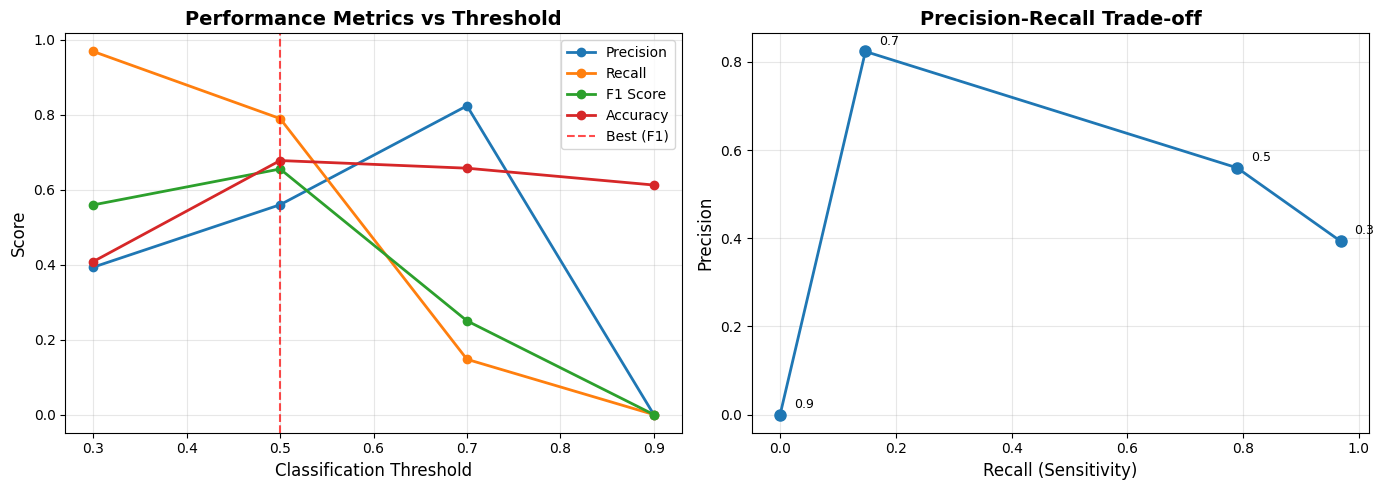

✓ Threshold analysis saved to: C:\Users\Brandon\Documents\DM_Project\output\threshold_analysis.png

Running final inference with optimal threshold: 0.50

✓ Detected 134 anomalies using threshold 0.50
  Correct predictions: 75
  False positives: 59


In [12]:
# Enhanced Inference with Threshold Adjustment

def evaluate_with_threshold(model, dataloader, threshold=0.5, device=DEVICE):
    """
    Evaluate model with adjustable decision threshold
    
    Args:
        threshold: Confidence threshold for crime classification (0.5 = default)
                   Higher threshold = more conservative (fewer false positives)
                   Lower threshold = more aggressive (fewer false negatives)
    """
    model.eval()
    
    all_probs = []
    all_labels = []
    all_paths = []
    
    with torch.no_grad():
        for clips, labels, paths in tqdm(dataloader, desc="Evaluating"):
            clips = clips.to(device)
            outputs, _ = model(clips, return_attention=True)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Crime probability
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_paths.extend(paths)
    
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    # Apply threshold
    predictions = (all_probs >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = (predictions == all_labels).mean()
    
    tp = ((predictions == 1) & (all_labels == 1)).sum()
    fp = ((predictions == 1) & (all_labels == 0)).sum()
    fn = ((predictions == 0) & (all_labels == 1)).sum()
    tn = ((predictions == 0) & (all_labels == 0)).sum()
    
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    specificity = tn / (tn + fp + 1e-10)
    
    print(f"\n{'='*60}")
    print(f"Evaluation Results (Threshold: {threshold:.2f})")
    print(f"{'='*60}")
    print(f"Accuracy:    {accuracy:.4f} ({100*accuracy:.2f}%)")
    print(f"Precision:   {precision:.4f} (Of predicted crimes, {100*precision:.1f}% are correct)")
    print(f"Recall:      {recall:.4f} (Of actual crimes, {100*recall:.1f}% are detected)")
    print(f"Specificity: {specificity:.4f} (Of normal videos, {100*specificity:.1f}% correctly identified)")
    print(f"F1 Score:    {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives:  {tn:4d} | False Positives: {fp:4d}")
    print(f"  False Negatives: {fn:4d} | True Positives:  {tp:4d}")
    print(f"{'='*60}\n")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'predictions': predictions,
        'probabilities': all_probs,
        'labels': all_labels,
        'paths': all_paths
    }


# Test different thresholds
print("Testing different classification thresholds...\n")

thresholds_to_test = [0.3, 0.5, 0.7, 0.9]
results = {}

for thresh in thresholds_to_test:
    results[thresh] = evaluate_with_threshold(model, test_loader, threshold=thresh)

# Find optimal threshold based on F1 score
best_threshold = max(results.keys(), key=lambda t: results[t]['f1'])
print(f"✓ Best threshold based on F1 score: {best_threshold:.2f}")
print(f"  F1 Score: {results[best_threshold]['f1']:.4f}")

# Visualize threshold impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot metrics vs threshold
thresholds = list(results.keys())
metrics = {
    'Precision': [results[t]['precision'] for t in thresholds],
    'Recall': [results[t]['recall'] for t in thresholds],
    'F1 Score': [results[t]['f1'] for t in thresholds],
    'Accuracy': [results[t]['accuracy'] for t in thresholds]
}

for metric_name, values in metrics.items():
    axes[0].plot(thresholds, values, marker='o', linewidth=2, label=metric_name)

axes[0].axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7, label=f'Best (F1)')
axes[0].set_xlabel('Classification Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Metrics vs Threshold', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROC-like curve (Recall vs Precision)
precisions = [results[t]['precision'] for t in thresholds]
recalls = [results[t]['recall'] for t in thresholds]

axes[1].plot(recalls, precisions, marker='o', linewidth=2, markersize=8)
for i, thresh in enumerate(thresholds):
    axes[1].annotate(f'{thresh:.1f}', (recalls[i], precisions[i]), 
                    textcoords="offset points", xytext=(10,5), fontsize=9)
axes[1].set_xlabel('Recall (Sensitivity)', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'threshold_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Threshold analysis saved to: {os.path.join(output_dir, 'threshold_analysis.png')}")

# Use best threshold for final inference
print(f"\nRunning final inference with optimal threshold: {best_threshold:.2f}")
final_results = results[best_threshold]

# Save anomalies detected with optimal threshold
anomaly_records = []
for i, (pred, prob, label, path) in enumerate(zip(
    final_results['predictions'],
    final_results['probabilities'], 
    final_results['labels'],
    final_results['paths']
)):
    if pred == 1:  # Predicted as crime
        anomaly_records.append({
            "video_path": path,
            "confidence": float(prob),
            "true_label": "Crime" if label == 1 else "Normal",
            "correct": bool(pred == label)
        })

print(f"\n✓ Detected {len(anomaly_records)} anomalies using threshold {best_threshold:.2f}")
print(f"  Correct predictions: {sum(r['correct'] for r in anomaly_records)}")
print(f"  False positives: {sum(1 for r in anomaly_records if not r['correct'])}")

### (Optional) Visualize Attention Weights
---


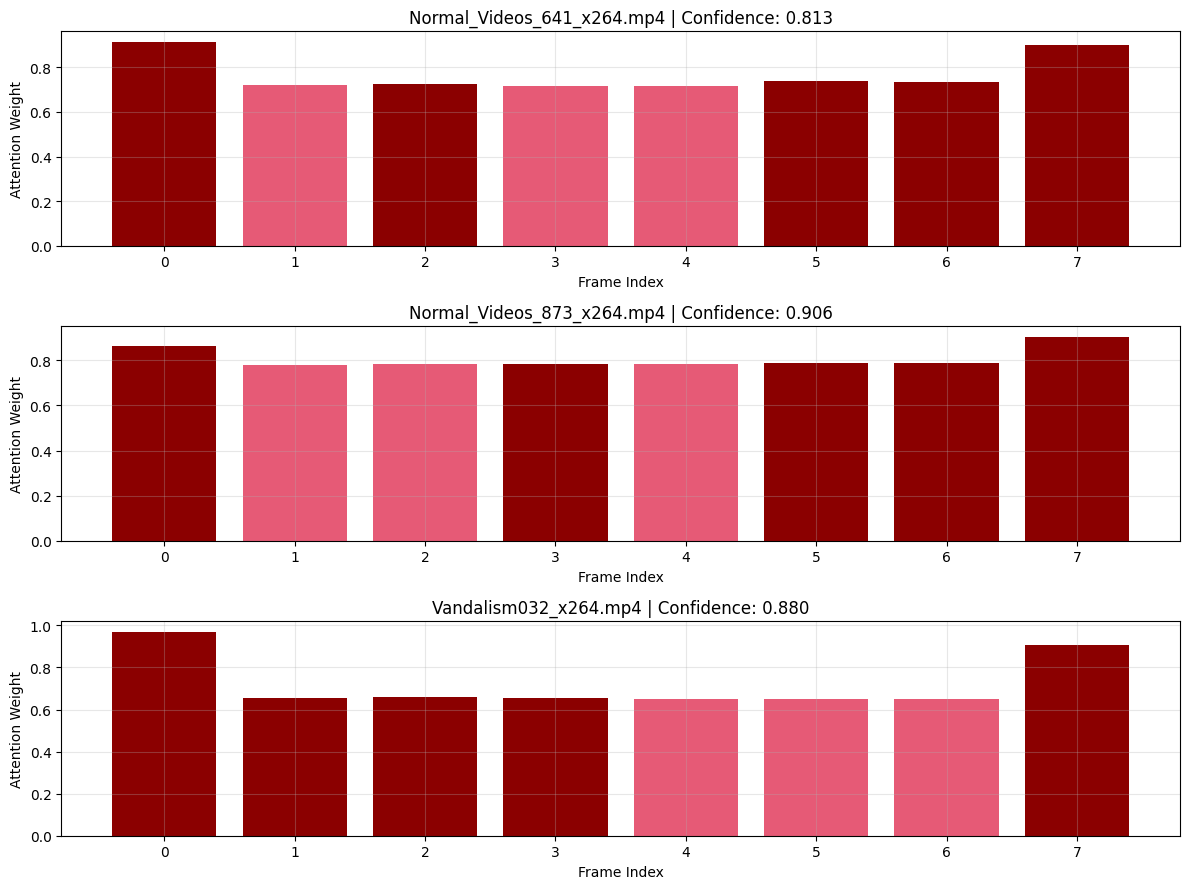


✓ Attention visualization saved to: ./stage1_output/attention_visualization.png


In [8]:
import matplotlib.pyplot as plt

def visualize_attention_examples(num_examples=3):
    """Visualize attention weights for a few crime examples"""
    if len(anomaly_records) == 0:
        print("No anomaly records found. Run inference first.")
        return
    
    # Select random examples
    import random
    examples = random.sample(anomaly_records, min(num_examples, len(anomaly_records)))
    
    fig, axes = plt.subplots(num_examples, 1, figsize=(12, 3*num_examples))
    if num_examples == 1:
        axes = [axes]
    
    for idx, example in enumerate(examples):
        video_name = os.path.basename(example['video_path'])
        attention = np.array(example['attention_weights'])
        confidence = example['confidence']
        
        axes[idx].bar(range(len(attention)), attention, color='crimson', alpha=0.7)
        axes[idx].set_xlabel('Frame Index')
        axes[idx].set_ylabel('Attention Weight')
        axes[idx].set_title(f'{video_name} | Confidence: {confidence:.3f}')
        axes[idx].grid(True, alpha=0.3)
        
        # Highlight top frames
        top_indices = example['top_attention_indices']
        for top_idx in top_indices:
            if top_idx < len(attention):
                axes[idx].bar(top_idx, attention[top_idx], color='darkred', alpha=1.0)
    
    plt.tight_layout()
    plt.savefig('./stage1_output/attention_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Attention visualization saved to: ./stage1_output/attention_visualization.png")

# Visualize if anomalies were detected
if len(anomaly_records) > 0:
    visualize_attention_examples(num_examples=min(3, len(anomaly_records)))
else:
    print("No anomalies detected to visualize.")
